# Logistic Regression on Titanic Dataset

**By: Anita Maskara**

In [156]:
# calling the required packages
library(dplyr)
library(ggplot2)
library(ggthemes)
library(corrgram)
library(corrplot)
library(caTools)
library(Amelia)
library(plotly)
library(irr)

In [157]:
## Load Titanic library to get the dataset
library(titanic)

## Load the datasets
data("titanic_train")
data("titanic_test")

## Adding Survived column for test data to NA so that rbind can work
titanic_test$Survived <- NA

## Combining Training and Testing dataset
complete_data <- rbind(titanic_train, titanic_test)

## Check data structure
str(complete_data)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


In [158]:
## Let's check for any duplicates in the data
sum(duplicated(complete_data))

[1] 0

In [159]:
## Let's check for any missing values in the data
colSums(is.na(complete_data))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1           0           0

418 missing values in Survived are from the test dataset. <br>
We will impute the ages that are missing <br>
The one row that has missing value in `Fare` column will be replaced with the average of `Fare`

In [160]:
## Checking for empty values
colSums(complete_data=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0          NA           0           0           0          NA 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0          NA        1014           2

In [161]:
My_Theme = theme(
  axis.title.x = element_text(size = 6, face='bold'),
  axis.text.x = element_text(size = 4, face = 'bold'),
  axis.text.y = element_text(size = 4),
  axis.title.y = element_text(size = 6, face='bold'))

Warning message:
"Removed 263 rows containing non-finite values (stat_boxplot)."

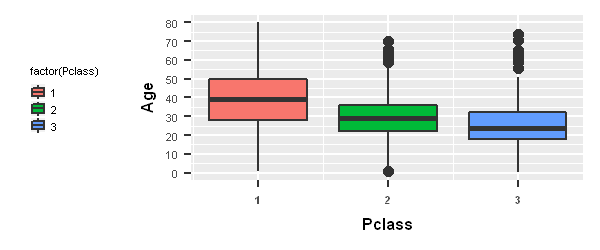

In [162]:
# Boxplot of Pclass and Age
ggplot(complete_data, aes(x=Pclass, y=Age)) + geom_boxplot(aes(group=Pclass, fill=factor(Pclass))) + scale_y_continuous(breaks = seq(min(0), max(80), by=10))+ My_Theme + theme(legend.position="left",legend.title=element_text(size=4), legend.key.size = unit(.2, "cm"),legend.text = element_text(size = 4))

**The average age of Pclass 1 is higher than Pclass 2. Also average age of Pclass 2 is higher than
average age of Pclass 3. This makes sense because to buy a Pclass 1 ticket requires you to be little wealthier
and it takes more years to acquire that kind of wealth.**

### Imputing the missing values in `Age` variable based on the above boxplot

In [163]:
# Imputing Age by using a function
impute_age <- function(age,class){
  out <- age
  for (i in 1:length(age)){
    if(is.na(age[i])){
      if(class[i]==1){
        out[i]<- 37
      }else if(class[i]==2){
        out[i]<- 29
        
      }else{
        out[i] <- 24
      }
    }else{
      out[i]<- age[i]
    }
  }
  return(out)
}

In [164]:
# Running the function
imputed_ages <- impute_age(complete_data$Age, complete_data$Pclass)

In [165]:
# Replacing na values in Age variable with imputed ages
complete_data$Age <- imputed_ages

In [217]:
# Deleting row that has missing value in Fare column 
complete_data <- complete_data[!is.na(complete_data$Fare), ]

In [218]:
# checking to see `Fare` variable does not have any more missing values
sum(is.na(complete_data$Fare))

[1] 0

**Cabin variable has a lot of missing values. Hence we will drop this variable**

In [168]:
complete_data <- select(complete_data, -Cabin)

In [169]:
# Finding the frequency count of Embarked
table(complete_data$Embarked)


      C   Q   S 
  2 270 123 914 

Since majority of passengers embarked from 'S', we will replace the missing value with 'S'

In [170]:
# Replacing missing value in Embarked variable
complete_data$Embarked[complete_data$Embarked==""] <- 'S'

In [171]:
## Check number of uniques values for each of the column to find out columns which we can convert to factors
sapply(complete_data, function(x) length(unique(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
       1309           3           3        1307           2          98 
      SibSp       Parch      Ticket        Fare    Embarked 
          7           8         929         282           3

In [172]:
## Removing passengerId, Ticket and Name as they are not required for logistic regression model
complete_data <- select(complete_data, -PassengerId, -Ticket, -Name)

In [173]:
# creating a copy of complete_data 
df <- complete_data

In [174]:
# Checking the structure of the dataset
str(df)

'data.frame':	1309 obs. of  8 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Sex     : chr  "male" "female" "female" "female" ...
 $ Age     : num  22 38 26 35 35 24 54 2 27 14 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: chr  "S" "C" "S" "S" ...


## Exploratory Data Analysis

### UNIVARIATE PLOTS

Warning message:
"Removed 418 rows containing non-finite values (stat_count)."

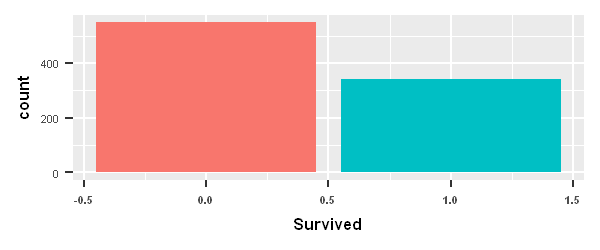

In [175]:
# Barplot for Suvived variable
options(repr.plot.width = 3, repr.plot.height = 1.25, repr.plot.res = 200)
print(ggplot(df, aes(Survived)) + geom_bar(aes(fill=factor(Survived))) + My_Theme + theme(legend.position="none"))

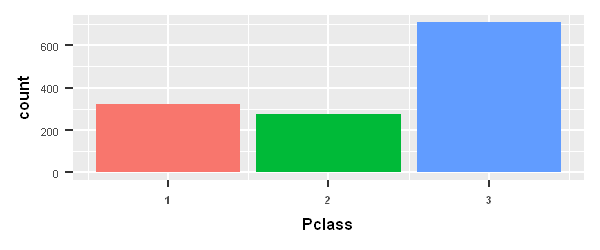

In [176]:
# Barplot for Pclass variable
options(repr.plot.width = 3, repr.plot.height = 1.25, repr.plot.res = 200)
print(ggplot(df, aes(Pclass)) + geom_bar(aes(fill=factor(Pclass))) + My_Theme + theme(legend.position="none"))

In [177]:
My_Theme = theme(
  axis.title.x = element_text(size = 6, face='bold'),
  axis.text.x = element_text(size = 4, face = 'bold'),
  axis.text.y = element_text(size = 4),
  axis.title.y = element_text(size = 6, face='bold'))

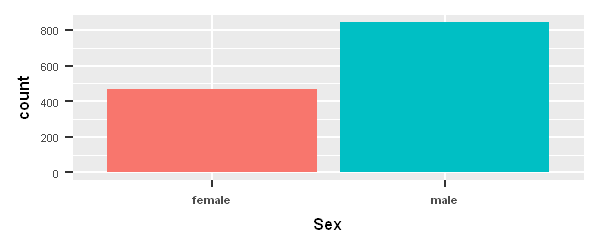

In [178]:
# Barplot for sex variable
options(repr.plot.width = 3, repr.plot.height = 1.25, repr.plot.res = 200)
print(ggplot(df, aes(Sex)) + geom_bar(aes(fill=factor(Sex))) + My_Theme + theme(legend.position="none"))

**there were a lot more males than females onboard.**

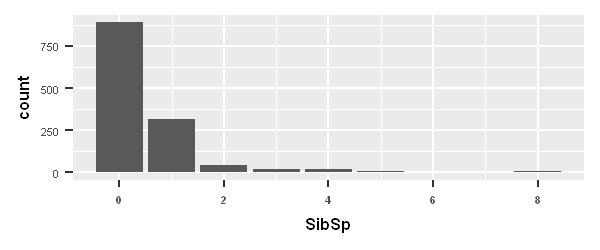

In [179]:
# Barplot for SibSp variable
print(ggplot(df, aes(SibSp)) + geom_bar() + My_Theme)


**Looks like majority of people did not have sibling or spouse onboard.**

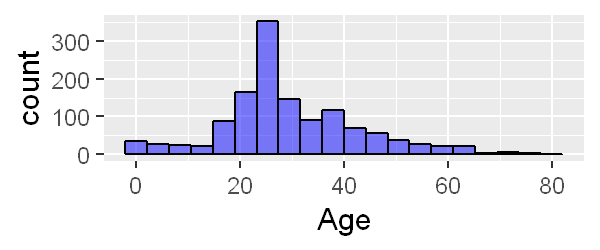

In [180]:
# Histogram of age
ggplot(df, aes(Age)) + geom_histogram(bins = 20, alpha = 0.5, fill='blue', color='black')

**Most people onboard were somewhere between the ages of 20 and 40 We have less older people. We have quite a few people below age 20 also.**

Warning message:
"Removed 1 rows containing non-finite values (stat_bin)."

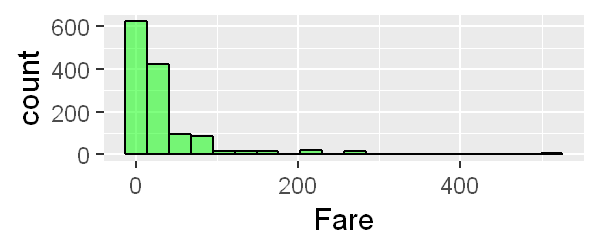

In [181]:
# Histogram of Fare variable
ggplot(df, aes(Fare)) + geom_histogram(bins = 20, alpha = 0.5, fill='green', color='black')

**Looks like most people paid a low fare which makes sense because a lot of people were on Pclass 3**

In [182]:
# Deleting the row that has missing value in Fare variable
df <- df[-c(1044),]

### BIVARIATE PLOTS

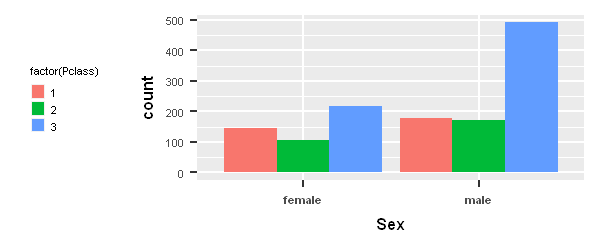

In [183]:
# Barplot of Sex and Pclass
print(ggplot(df, aes(Sex,  main="Title")) + geom_bar(aes(fill=factor(Pclass)), position="dodge") + My_Theme + theme(legend.position="left",legend.title=element_text(size=4), legend.key.size = unit(.2, "cm"),legend.text = element_text(size = 4)))

In [184]:
# Converting "Survived","Pclass","Sex","Embarked" to factors

for(i in c("Survived","Pclass","Sex","Embarked")){
    df[,i]=as.factor(df[,i])
}

# Creating dummy variables for factor variables
library(dummies)
df <- dummy.data.frame(df, names=c("Pclass","Sex","Embarked"), sep="_")

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"

In [185]:
# reviewing the dataframe
head(df)

Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1,0,1,22,1,0,7.2500,0,0,1
1,1,0,0,1,0,38,1,0,71.2833,1,0,0
1,0,0,1,1,0,26,0,0,7.9250,0,0,1
1,1,0,0,1,0,35,1,0,53.1000,0,0,1
0,0,0,1,0,1,35,0,0,8.0500,0,0,1
0,0,0,1,0,1,24,0,0,8.4583,0,1,0


In [186]:
str(df)

'data.frame':	1308 obs. of  13 variables:
 $ Survived  : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass_1  : int  0 1 0 1 0 0 1 0 0 0 ...
 $ Pclass_2  : int  0 0 0 0 0 0 0 0 0 1 ...
 $ Pclass_3  : int  1 0 1 0 1 1 0 1 1 0 ...
 $ Sex_female: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Sex_male  : int  1 0 0 0 1 1 1 1 0 0 ...
 $ Age       : num  22 38 26 35 35 24 54 2 27 14 ...
 $ SibSp     : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch     : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare      : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked_C: int  0 1 0 0 0 0 0 0 0 1 ...
 $ Embarked_Q: int  0 0 0 0 0 1 0 0 0 0 ...
 $ Embarked_S: int  1 0 1 1 1 0 1 1 1 0 ...
 - attr(*, "dummies")=List of 3
  ..$ Pclass  : int  2 3 4
  ..$ Sex     : int  5 6
  ..$ Embarked: int  11 12 13


### Building logistic regression model

In [187]:
## Splitting training and test data
train <- df[1:667,]
test <- df[668:889, ]

## Model Creation
model <- glm(Survived ~.,family=binomial(link='logit'),data=train)

## Model Summary
summary(model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4349  -0.6522  -0.4234   0.6340   2.4240  

Coefficients: (3 not defined because of singularities)
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.320772   0.321431  -4.109 3.97e-05 ***
Pclass_1     2.309404   0.373105   6.190 6.03e-10 ***
Pclass_2     1.344099   0.273413   4.916 8.83e-07 ***
Pclass_3           NA         NA      NA       NA    
Sex_female   2.680826   0.227509  11.783  < 2e-16 ***
Sex_male           NA         NA      NA       NA    
Age         -0.034440   0.009316  -3.697 0.000218 ***
SibSp       -0.258775   0.124057  -2.086 0.036984 *  
Parch       -0.094577   0.143037  -0.661 0.508480    
Fare        -0.001592   0.003185  -0.500 0.617070    
Embarked_C   0.400614   0.272425   1.471 0.141413    
Embarked_Q   0.463049   0.370351   1.250 0.211190    
Embarked_S         NA         NA      N

In [ ]:
## Using anova() to analyze the table of devaiance
anova(model, test="Chisq")

Analysis of Deviance Table

Model: binomial, link: logit

Response: Survived

Terms added sequentially (first to last)


           Df Deviance Resid. Df Resid. Dev  Pr(>Chi)    
NULL                         666     891.99              
Pclass_1    1   39.603       665     852.39 3.112e-10 ***
Pclass_2    1   26.485       664     825.91 2.655e-07 ***
Pclass_3    0    0.000       664     825.91              
Sex_female  1  197.978       663     627.93 < 2.2e-16 ***
Sex_male    0    0.000       663     627.93              
Age         1   10.473       662     617.45  0.001211 ** 
SibSp       1    8.712       661     608.74  0.003162 ** 
Fare        1    0.263       660     608.48  0.608287    
Embarked_   1    0.175       659     608.31  0.676059    
Embarked_C  1    1.776       658     606.53  0.182588    
Embarked_Q  1    1.897       657     604.63  0.168457    
Embarked_S  0    0.000       657     604.63              
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [209]:
# CHECKING PREDICTION ACCURACY
fitted.probabilities <- predict(model, newdata=test, type='response')

# Now let's calculate from the predicted values:
fitted.results <- ifelse(fitted.probabilities > 0.5,1,0)


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

In [210]:
# Checking the accuracy of the data
misClasificError <- mean(fitted.results != test$Survived)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.828828828828829"


In [211]:
kappa2(data.frame(test$Survived,  result))

 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 222 
   Raters = 2 
    Kappa = 0.619 

        z = 9.29 
  p-value = 0 

In [ ]:
## Confusion matrix and statistics
library(caret)
confusionMatrix(data=result, reference=test$Survived)

 Confusion Matrix and Statistics

          Reference
 Prediction   0   1
          0 128  25
          1  13  56
                                           
                Accuracy : 0.8288          
                  95% CI : (0.7727, 0.8759)
     No Information Rate : 0.6351          
     P-Value [Acc > NIR] : 1.817e-10       
                                           
                   Kappa : 0.6187          
  Mcnemar's Test P-Value : 0.07435         
                                           
             Sensitivity : 0.9078          
             Specificity : 0.6914          
          Pos Pred Value : 0.8366          
          Neg Pred Value : 0.8116          
              Prevalence : 0.6351          
          Detection Rate : 0.5766          
    Detection Prevalence : 0.6892          
       Balanced Accuracy : 0.7996          
                                           
        'Positive' Class : 0               
 

In [ ]:
## ROC Curve and calculating the area under the curve(AUC)
library(ROCR)
predictions <- predict(model, newdata=test, type="response")
ROCRpred <- prediction(predictions, test$Survived)
ROCRperf <- performance(ROCRpred, measure = "tpr", x.measure = "fpr")

plot(ROCRperf, colorize = TRUE, text.adj = c(-0.2,1.7), print.cutoffs.at = seq(0,1,0.1))

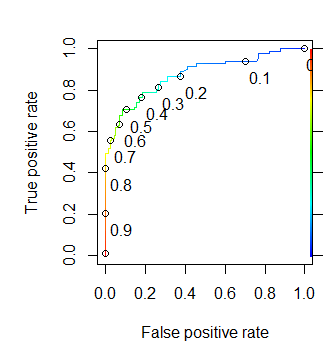

In [208]:
auc <- performance(ROCRpred, measure = "auc")
auc <- auc@y.values[[1]]
auc

[1] 0.8737851